In [2]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pillow-10.4.0-cp38-cp38-win_amd64.whl.metadata (9.3 kB)
  Using cached pyparsing-3.1.4-py3-none-any.whl.metadata (5.1 kB)
   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/7.5 MB 7.2 MB/s eta 0:00:01
   --------- ------------------------------ 1.8/7.5 MB 5.6 MB/s eta 0:00:02
   ------------ --------------------------- 2.4/7.5 MB 4.3 MB/s eta 0:00:02
   --------------- ------------------------ 2.9/7.5 MB 4.0 MB/s eta 0:00:02
   ------------------- -------------------- 3.7/7.5 MB 3.6 MB/s eta 0:00:02
   ---------------------- ----------------- 4.2/7.5 MB 3.4 MB/s eta 0:00:01
   ------------------------- -------------- 4.7/7.5 MB 3.3 MB/s eta 0:00:01
   --------------------------- ------------ 5.2/7.5 MB 3.2 MB/s eta 0:00:01
   ------------------------------ --------- 5.8/7.5 MB 3.2 MB/s eta 0:00:01
   --------------------------------- ------ 6.

#### Importing the libraries

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch.nn.functional as F

#### Root data directory part

In [2]:
data_dir = r"C:\Users\Lokesh\PycharmProjects\Signature_Recognition\notebook\Signature_data"

#### Total number of classes

In [3]:
class_name = os.listdir(data_dir)
len(class_name)

2

In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms as T, datasets

#### Checking the CUDA availability

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:{}".format(device))

Device:cpu


#### Transforming the data

In [6]:
data_transform = T.Compose([T.Resize(size=(224,224)), #Resizing the image to be 224 by 224
                            T.RandomRotation(degrees=(-20,+20)), #Randomly rotate images by +/- 20 degrees, Image Augmentation for each epoch
                            T.ToTensor(), #Converting dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                            T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) #Normalize by 3 mean 3 STD's of the image net, 3 channels
                           ])
                            

In [7]:
data = datasets.ImageFolder(data_dir, transform=data_transform)
total_count = len(data)

In [8]:
total_count

2640

In [9]:
data.classes

['Forged', 'Original']

#### Splitting the data

In [10]:
train_count = int(0.6 * total_count)
valid_count = int(0.3 * total_count)
test_count = total_count - train_count - valid_count
train_data, valid_data, test_data = torch.utils.data.random_split(data, (train_count, valid_count, test_count))

In [11]:
len(train_data.indices)

1584

In [12]:
len(test_data.indices)

264

In [13]:
len(valid_data.indices)

792

#### Defining some functions

In [14]:
def show_image(image,label,get_denormalize = True):

    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])

    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)

    else:
        plt.imshow(image)
        plt.title(label)

def accuracy(y_pred, y_true):
    y_pred = F.softmax(y_pred, dim=1)
    top_p,top_class = y_pred.topk(1, dim=1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))
    

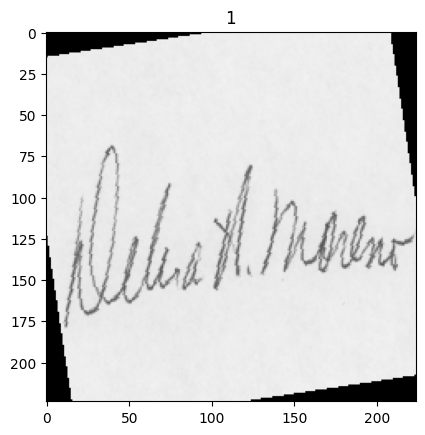

In [15]:
img, label = train_data[0]
show_image(img, label)

#### Data Loaders

In [16]:
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)
print("No. of batches in trainloader: {}".format(len(trainloader)))
print("No. of Total examples: {}".format(len(trainloader.dataset)))

validationloader = DataLoader(valid_data, batch_size=32, shuffle=True)
print("No. of batches in validationloader: {}".format(len(validationloader)))
print("No. of Total examples: {}".format(len(validationloader.dataset)))

testloader = DataLoader(test_data, batch_size=32, shuffle=False)
print("No. of batches in testloader: {}".format(len(testloader)))
print("No. of Total examples: {}".format(len(testloader.dataset)))

No. of batches in trainloader: 50
No. of Total examples: 1584
No. of batches in validationloader: 25
No. of Total examples: 792
No. of batches in testloader: 9
No. of Total examples: 264


#### Model

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms

In [19]:
model = models.resnet34(pretrained=True)

C:\Users\Lokesh\anaconda3\envs\Signature_Recognition\envs\seg\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Lokesh\anaconda3\envs\Signature_Recognition\envs\seg\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\Lokesh/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:52<00:00, 

In [20]:
model.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(model.fc.in_features, len(class_name))
)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9) 

#### Model training function require by Pytorch

In [21]:
def train(model, criterion, optimizer, train_dataloader, test_dataloader):

    total_train_loss = 0
    total_test_loss = 0

    model.train()
    with tqdm(train_dataloader, unit='batch', leave=False) as pbar:
        pbar.set_description(f'training')
        for images, idxs in pbar:
            images = images.to(device, non_blocking=True)
            idxs = idxs.to(device, non_blocking=True)
            output = model(images)

            loss = criterion(output, idxs)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            
    model.eval()
    with tqdm(test_dataloader, unit='batch', leave=False) as pbar:
        pbar.set_description(f'testing')
        for images, idxs in pbar:
            images = images.to(device, non_blocking=True)
            idxs = idxs.to(device, non_blocking=True)
            output = model(images)

            loss = criterion(output, idxs)
            total_test_loss += loss.item()

    train_acc = total_train_loss / len(train_data)
    test_acc = total_test_loss / len(valid_data)
    print(f'Train loss: {train_acc:.4f} Test loss: {test_acc:.4f}')

In [23]:
%%time
epochs=5
for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")
    train(model, criterion, optimizer, trainloader, validationloader)

Epoch 1/5


Train loss: 0.0004 Test loss: 0.0003
Epoch 2/5


Train loss: 0.0004 Test loss: 0.0001
Epoch 3/5


Train loss: 0.0003 Test loss: 0.0002
Epoch 4/5


Train loss: 0.0002 Test loss: 0.0000
Epoch 5/5


Train loss: 0.0003 Test loss: 0.0001
CPU times: total: 2h 2min 43s
Wall time: 41min 18s


#### Model Saving

In [24]:
pwd

'C:\\Users\\Lokesh\\PycharmProjects\\Signature_Recognition\\notebook'

In [25]:
Path = r'C:\\Users\\Lokesh\\PycharmProjects\\Signature_Recognition\\notebook\\model.pt'
torch.save(model, Path)

#### Loading torch model

In [26]:
# Model class must be defined somewhere
model = torch.load(Path)
model.eval()

C:\Users\Lokesh\AppData\Local\Temp\ipykernel_6092\424075518.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(Path)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Model Evaluation

In [27]:
def evaluate(model, criterion, optimizer, test_dataloader):
    total_test_loss = 0

    model.eval()
    with tqdm(test_dataloader, unit='batch', leave=False) as pbar:
        pbar.set_description(f'testing')
        for images, idxs in pbar:
            images = images.to(device, non_blocking=True)
            idxs = idxs.to(device, non_blocking=True)
            output = model(images)

            loss = criterion(output, idxs)
            total_test_loss += loss.item()

    test_acc = total_test_loss / len(valid_data)
    print(f'Test loss: {test_acc:.4f}')

In [28]:
evaluate(model, criterion, optimizer, testloader)

Test loss: 0.0000


#### Prediction

In [29]:
label_names = data.classes
label_names

['Forged', 'Original']

In [31]:
from PIL import Image

#Load the image and preprocess it
image = Image.open(r'C:\Users\Lokesh\PycharmProjects\Signature_Recognition\notebook\Signature_data\Original\original_1_1.png')
preprocess = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor()
])

image = preprocess(image)
image = image[:3]

#Convert the image to a PyTorch tensor and send it to the drive 
image = image.unsqueeze(0).to(device)

#Make prediction
with torch.no_grad():
    logits = model(image)
    probs = torch.softmax(logits, dim=1)
    pred_label = torch.argmax(probs, dim=1)

#Print the prediction
print(f'Predicted label: {pred_label.item()}')

#Make the predicted label to the corresponding class name
predicted_class_name = label_names[pred_label.item()]

#Print the predicted class name
print(f'Predicted class name: {predicted_class_name}')

Predicted label: 1
Predicted class name: Original
